In [384]:
import os
import pandas as pd
import matplotlib.pyplot as plt
os.chdir("/Users/Sarah/Desktop")
df = pd.read_csv("blood_markers.csv")
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
import xgboost
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.svm import SVC
import sys
#!{sys.executable} -m pip install mlxtend
from mlxtend.evaluate import feature_importance_permutation


In [385]:
df.dropna(inplace=True)

df = df[~df['Group'].isin(['analysis error/unclassifiable', 'insuff follow-up'])]
y = df['Group'].replace('PSE', 'epilepsy', inplace=True)
y = df['Group'].replace('epilepsy', 1, inplace=True)
y = df['Group'].replace('single seizure', 0, inplace=True)
y = df['Group']
X = df.drop(['Group', 'patient_number'], axis=1)
X['Gender'] = X['Gender'].replace({'Male': 0, 'Female': 1})

In [386]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 2/7)

In [387]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [388]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, n_estimators=1000)
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)

[0.31522648 0.10632248 0.15075693 0.1137661  0.1626264  0.03260873
 0.11869287]
Feature: 0, Score: 0.31523
Feature: 1, Score: 0.10632
Feature: 2, Score: 0.15076
Feature: 3, Score: 0.11377
Feature: 4, Score: 0.16263
Feature: 5, Score: 0.03261
Feature: 6, Score: 0.11869


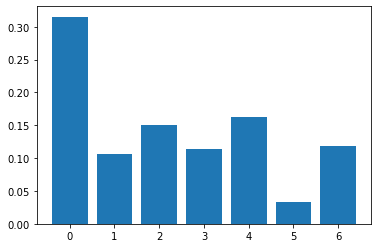

In [389]:
print(rfc.feature_importances_)
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

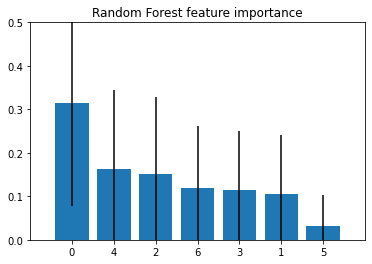

In [390]:
std = np.std([rfc.feature_importances_ for rfc in rfc.estimators_],
             axis=0)
indices = np.argsort(rfc.feature_importances_)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Random Forest feature importance")
plt.bar(range(X.shape[1]), rfc.feature_importances_[indices],
        yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.5])
plt.show()

In [391]:
important_values = feature_importance_permutation(
    predict_method=rfc.predict, 
    X=X_test_scaled,
    y=y_test,
    metric='accuracy',
    num_rounds=1,
    seed=1)

print(important_values)

(array([ 0.04761905, -0.04761905, -0.0952381 , -0.04761905, -0.14285714,
        0.        ,  0.        ]), array([[ 0.04761905],
       [-0.04761905],
       [-0.0952381 ],
       [-0.04761905],
       [-0.14285714],
       [ 0.        ],
       [ 0.        ]]))


In [392]:
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)

[18:32:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Sarah/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Feature: 0, Score: 0.17047
Feature: 1, Score: 0.03187
Feature: 2, Score: 0.07687
Feature: 3, Score: 0.01891
Feature: 4, Score: 0.29532
Feature: 5, Score: 0.36126
Feature: 6, Score: 0.04529


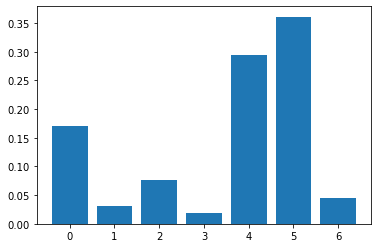

In [393]:
importance = xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [394]:
svm = SVC(C=1.0, kernel='rbf')
svm.fit(X_train_scaled, y_train)

print('Training accuracy', np.mean(svm.predict(X_train_scaled) == y_train)*100)
print('Test accuracy', np.mean(svm.predict(X_test_scaled) == y_test)*100)

Training accuracy 89.28571428571429
Test accuracy 71.42857142857143


[ 0.20357143  0.00714286 -0.00357143  0.01785714  0.07142857  0.17142857
  0.09642857]


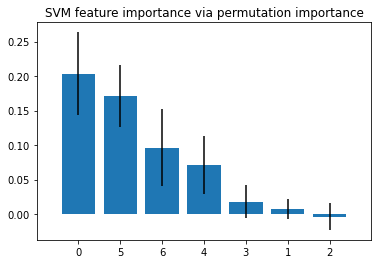

In [395]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=svm.predict, 
    X=X_train_scaled,
    y=y_train,
    metric='accuracy',
    num_rounds=10,
    seed=1)

print (imp_vals)

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("SVM feature importance via permutation importance")
plt.bar(range(X.shape[1]), imp_vals[indices], yerr=std[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [396]:
mlp = MLPClassifier()
mlp.fit(X_train_scaled, y_train)

print('Training accuracy', np.mean(mlp.predict(X_train_scaled) == y_train)*100)
print('Test accuracy', np.mean(mlp.predict(X_test_scaled) == y_test)*100)

Training accuracy 85.71428571428571
Test accuracy 57.14285714285714


/Users/Sarah/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.18214286 0.02857143 0.025      0.04285714 0.08571429 0.07142857
 0.03214286]


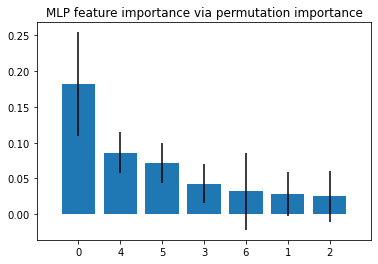

In [397]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=mlp.predict, 
    X=X_train_scaled,
    y=y_train,
    metric='accuracy',
    num_rounds=10,
    seed=1)

print(imp_vals)

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("MLP feature importance via permutation importance")
plt.bar(range(X.shape[1]), imp_vals[indices], yerr=std[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [398]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)

print('Training accuracy', np.mean(rfc.predict(X_train_scaled) == y_train)*100)
print('Test accuracy', np.mean(rfc.predict(X_test_scaled) == y_test)*100)

Training accuracy 100.0
Test accuracy 47.61904761904761


[0.27142857 0.025      0.025      0.025      0.075      0.
 0.00714286]


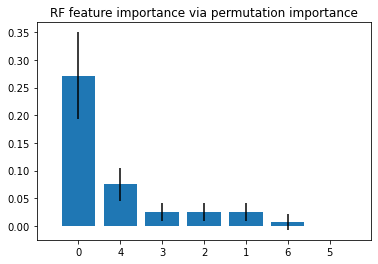

In [399]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=rfc.predict, 
    X=X_train_scaled,
    y=y_train,
    metric='accuracy',
    num_rounds=10,
    seed=1)

print(imp_vals)

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("RF feature importance via permutation importance")
plt.bar(range(X.shape[1]), imp_vals[indices], yerr=std[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [400]:
xgb.fit(X_train_scaled, y_train)

print('Training accuracy', np.mean(xgb.predict(X_train_scaled) == y_train)*100)
print('Test accuracy', np.mean(xgb.predict(X_test_scaled) == y_test)*100)

[18:32:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy 96.42857142857143
Test accuracy 42.857142857142854


/Users/Sarah/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0.35357143 0.         0.04285714 0.04285714 0.05357143 0.
 0.        ]


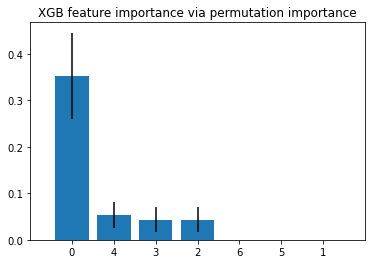

In [401]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=xgb.predict, 
    X=X_train_scaled,
    y=y_train,
    metric='accuracy',
    num_rounds=10,
    seed=1)

print(imp_vals)

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("XGB feature importance via permutation importance")
plt.bar(range(X.shape[1]), imp_vals[indices], yerr=std[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()